# load dataset

In [1]:
import os
data_dir = 'E:\\Datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname, encoding='utf-8')
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### Parsing the data

In [9]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data[0])

[  9.96520000e+02  -8.02000000e+00   2.65400000e+02  -8.90000000e+00
   9.33000000e+01   3.33000000e+00   3.11000000e+00   2.20000000e-01
   1.94000000e+00   3.12000000e+00   1.30775000e+03   1.03000000e+00
   1.75000000e+00   1.52300000e+02]


In [10]:
float_data.shape

(420551, 14)

### Plotting the temperature timeseries

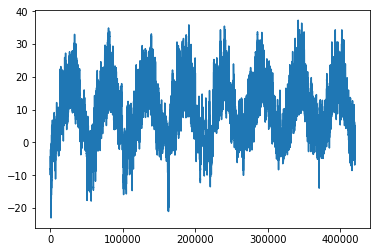

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

### Plotting the first 10 days of the temperature timeseries
Because the data is recorded every 10 minutes, you get 144 data points per day

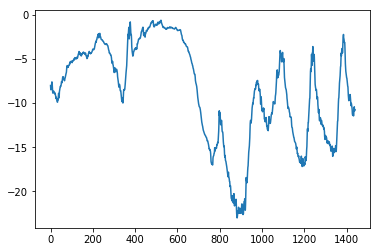

In [15]:
plt.plot(range(1440), temp[:1440])

# Data preprocessing
Preprocess the data to a format a neural network can ingest. This is easy: the
data is already numerical, so you don’t need to do any vectorization. But each
timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is
around 1,000). You’ll normalize each timeseries independently so that they all
take small values on a similar scale

In [18]:
mean = float_data[:200000].mean(axis=0)

In [19]:
mean

array([  988.88635885,     9.07734895,   283.14631345,     4.44854725,
          75.35405895,    13.3829553 ,     9.29695535,     4.08591725,
           5.8752111 ,     9.40521005,  1217.51429655,     2.1510037 ,
           3.56950915,   176.21703355])

In [20]:
float_data -= mean

In [21]:
std = float_data[:200000].std(axis=0)
std

array([  8.48043388,   8.85249908,   8.95324185,   7.16584991,
        16.72731652,   7.68914559,   4.19808168,   4.84034436,
         2.66564926,   4.25206364,  42.48884277,   1.53666449,
         2.33067298,  86.61322998])

In [22]:
float_data /= std

In [23]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])